In [2]:
import numpy as np
import pandas as pd 
from random import random
import time
import warnings
import shap
import os 

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings(action='ignore') 

c:\Users\JUNGINKIM\anaconda3\envs\ba2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.Make train data

In [4]:
# Simple preprocessing and standardization of train data
le = LabelEncoder()

train = pd.read_csv('./data/train.csv') # Replacing Missing values using k-means
X_train = train.drop(['freq'],axis = 1)
y_train = train['freq']

# Used to encode stnNm features
le.fit(X_train['stnNm'])
X_train['stnNm'] = le.transform(X_train['stnNm'])

# Converting to an integer type of feature related to the population 
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].apply(lambda x : x.replace(',',''))
        X_train[col] = X_train[col].astype(int)

# 2. Make test data

In [5]:
# Preprocessing of test data

le = LabelEncoder()
le_tm = LabelEncoder()

test = pd.read_csv('./data/test.csv')
test.rename(columns={'yyyymmdd':'tm','area':'stnNm'},inplace=True)
test.sort_values(by = ['tm','sex'], axis=0,inplace=True)
test.reset_index(drop=True,inplace=True)
test.drop(['frequency'],axis = 1,inplace=True)

le.fit(test['stnNm'])
test['stnNm'] = le.transform(test['stnNm'])

test['tm'] = test['tm'].apply(lambda x: x.replace('-','')).astype(int) # test['tm'].str.replace('-','')

for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].apply(lambda x : x.replace(',',''))
        test[col] = test[col].astype(int)

# Encoding Time feature
le_tm.fit(pd.concat([X_train,test],axis=0,ignore_index = True).tm) # X_train -> 0 ~ 49673 / test -> 49674 ~

X_train['tm'] = le_tm.transform(X_train['tm'])
test['tm'] = le_tm.transform(test['tm'])

# 4.LGBM 

In [7]:
def lgb_objective(trial):
    lgb_learning_rate = trial.suggest_float('learning_rate', 0.04, 0.4)
    lgb_leaves= trial.suggest_int('num_leaves', 10, 1000)
    lgb_bytree = trial.suggest_float("colsample_bytree", 0.1,0.3)
    lgb_subsample = trial.suggest_float("subsample", 0.1,0.3)
    lgb_depth =  trial.suggest_int('max_depth', 3, 100)
    lgb_child_samples = trial.suggest_int('min_child_samples', 3, 2000)
    lgb_alpha =  trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    lgb_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    lgb_smooth = trial.suggest_int('cat_smooth', 1, 100)
    lgb_gain_to_split = trial.suggest_float('min_split_gain', 0.0, 30.0)
    lgb_max_bin = trial.suggest_int('max_bin',2,100)
    lgb_boosting = trial.suggest_categorical('boosting_type', ['gbdt','dart'])
    lgb_bagging = trial.suggest_uniform('bagging_fraction', 0.1, 1.0)
    lgb_bagging_freq =  trial.suggest_int('bagging_freq', 0, 15)

    regressor_obj = LGBMRegressor(boosting_type=lgb_boosting,objective='regression', metric='rmse', verbosity = -1,num_leaves=lgb_leaves,learning_rate=lgb_learning_rate
                                ,colsample_bytree= lgb_bytree, subsample=lgb_subsample, max_depth=lgb_depth, min_child_samples=lgb_child_samples,reg_alpha=lgb_alpha,
                                reg_lambda=lgb_lambda,cat_smooth=lgb_smooth,min_split_gain=lgb_gain_to_split,max_bin = lgb_max_bin
                                ,bagging_fraction=lgb_bagging,bagging_freq=lgb_bagging_freq)
                              

    rmse = np.sqrt(-cross_val_score(regressor_obj, X_train, y_train, scoring="neg_mean_squared_error", cv = 12, n_jobs=8))
    rmse =  np.mean(rmse)
    return rmse

def LGBMregreesr(trials):
    sampler = TPESampler(seed=42) # TPESampler --> MAE가 최소가 되는 방향으로 학습 진행 (MAE: 평균절대오차!)

    study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
    study_lgb.optimize(lgb_objective, n_trials=trials)

    print("Number of finished trials: {}".format(len(study_lgb.trials)))

    print("Best trial:")
    trial = study_lgb.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return study_lgb

## 4-1. all data

In [ ]:
# 전체 데이터 셋에 대해 최적의 파라미터 찾고 RFE를 통해 feature select 

model = LGBMregreesr(150)
lgb_best_all = model.best_params

model_lgb = LGBMRegressor(**lgb_best_all)

model_lgb.fit(X_train,y_train)

## 4-2. RFE data

In [7]:
############################--------Make RFE DATASET--------#####################################
cv = KFold(n_splits=10, shuffle=True)
rfe = RFECV(estimator=LGBMRegressor(**lgb_best_all))

rfe.fit(X_train,y_train)

select_feature = []

for i,col in enumerate(X_train.columns):
    print('Column: %s, Selected: %s, Rank: %.3f' % (col, rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True :
        select_feature.append(col)

for col in ['stnNm', 'sex']:
    if col not in select_feature:
        select_feature.append(col)

X_train_all_rfe = X_train[select_feature]
test_all_rfe = test[select_feature]

print(select_feature)

X_train = X_train_all_rfe

model = LGBMregreesr(150)
lgb_best_all_rfe = model.best_params

model_lgb_rfe = LGBMRegressor(**lgb_best_all_rfe)

model_lgb_rfe.fit(X_train,y_train)
pred_lgb_rfe = model_lgb_rfe.predict(test_all_rfe)

df = pd.read_csv('./220153.csv',encoding='cp949')
df['frequency'] = pred_lgb_rfe
df.to_csv('./result/220153_rfe.csv',encoding='cp949',index=False)

[LightGBM] [Warning] bagging_fraction is set=0.8586202607443169, subsample=0.18680755656265954 will be ignored. Current value: bagging_fraction=0.8586202607443169
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8586202607443169, subsample=0.18680755656265954 will be ignored. Current value: bagging_fraction=0.8586202607443169
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8586202607443169, subsample=0.18680755656265954 will be ignored. Current value: bagging_fraction=0.8586202607443169
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8586202607443169, subsample=0.18680755656265954 will be ignored. Current value: bagging_fraction=0.8586202607443169
[LightGBM] [Warning] bag

[I 2022-08-06 18:33:12,589] A new study created in memory with name: no-name-a0200d57-fa0c-4b83-95fb-48518e0fe991


Column: stnNm, Selected: True, Rank: 1.000
Column: tm, Selected: True, Rank: 1.000
Column: sex, Selected: True, Rank: 1.000
Column: avgTa, Selected: True, Rank: 1.000
Column: minTa, Selected: True, Rank: 1.000
Column: maxTa, Selected: True, Rank: 1.000
Column: sumRn, Selected: True, Rank: 1.000
Column: maxWs, Selected: True, Rank: 1.000
Column: avgWs, Selected: True, Rank: 1.000
Column: avgTd, Selected: True, Rank: 1.000
Column: minRhm, Selected: True, Rank: 1.000
Column: avgRhm, Selected: True, Rank: 1.000
Column: avgPv, Selected: True, Rank: 1.000
Column: avgPa, Selected: True, Rank: 1.000
Column: avgPs, Selected: True, Rank: 1.000
Column: avgTs, Selected: True, Rank: 1.000
Column: minTg, Selected: True, Rank: 1.000
Column: 체감온도, Selected: True, Rank: 1.000
Column: 총_인구수, Selected: True, Rank: 1.000
Column: 10세이하_인구수, Selected: True, Rank: 1.000
Column: 10대_인구수, Selected: True, Rank: 1.000
Column: 20대_인구수, Selected: True, Rank: 1.000
Column: 30대_인구수, Selected: True, Rank: 1.000
Colum

[I 2022-08-06 18:33:14,780] Trial 0 finished with value: 1.3107412014048605 and parameters: {'learning_rate': 0.17483444278505053, 'num_leaves': 952, 'colsample_bytree': 0.24639878836228102, 'subsample': 0.2197316968394073, 'max_depth': 18, 'min_child_samples': 314, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.08499808989182997, 'cat_smooth': 61, 'min_split_gain': 21.242177333881365, 'max_bin': 4, 'boosting_type': 'gbdt', 'bagging_fraction': 0.29110519961044856, 'bagging_freq': 2}. Best is trial 0 with value: 1.3107412014048605.
[I 2022-08-06 18:33:16,402] Trial 1 finished with value: 1.2672310786544498 and parameters: {'learning_rate': 0.10602562354723619, 'num_leaves': 311, 'colsample_bytree': 0.20495128632644755, 'subsample': 0.18638900372842315, 'max_depth': 31, 'min_child_samples': 1225, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 2.1734877073417355e-06, 'cat_smooth': 37, 'min_split_gain': 13.682099526511077, 'max_bin': 79, 'boosting_type': 'dart', 'bagging_fraction

Number of finished trials: 150
Best trial:
  Value: 1.2540025424007821
  Params: 
    learning_rate: 0.1964308949827561
    num_leaves: 208
    colsample_bytree: 0.28721048951184647
    subsample: 0.18680755656265954
    max_depth: 45
    min_child_samples: 1123
    reg_alpha: 5.6811780824654326e-08
    reg_lambda: 2.595350541997396e-06
    cat_smooth: 85
    min_split_gain: 16.56016622575537
    max_bin: 95
    boosting_type: gbdt
    bagging_fraction: 0.8586202607443169
    bagging_freq: 2


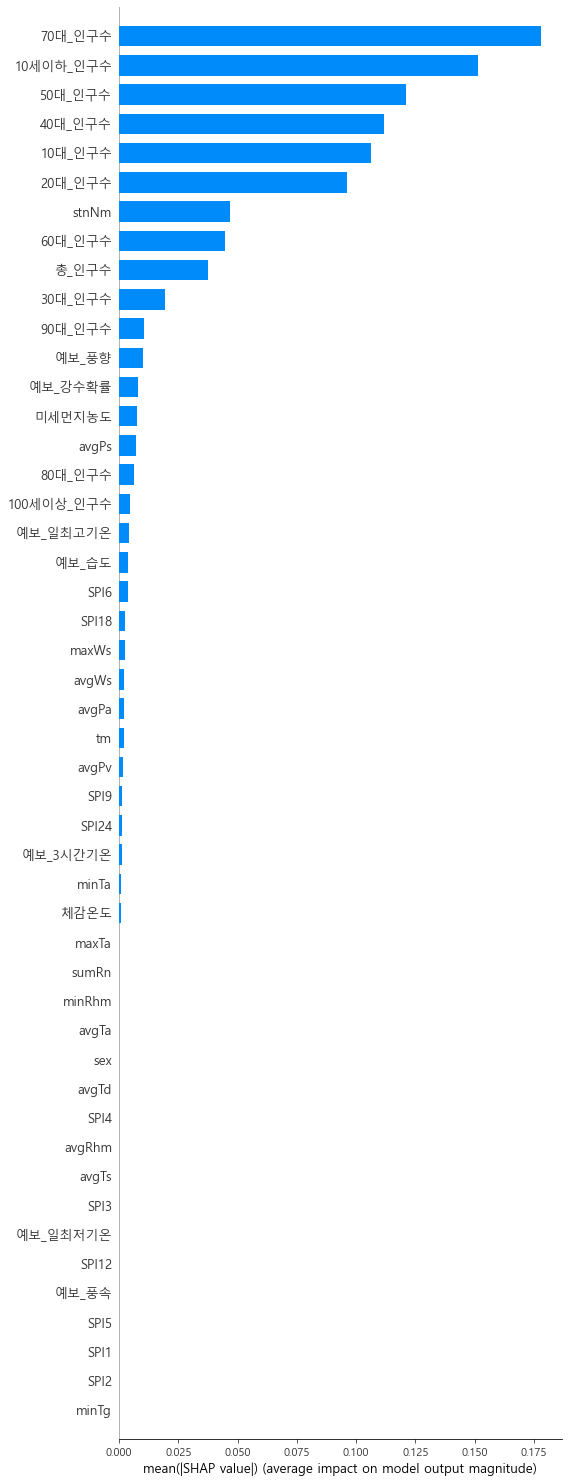

In [21]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.facecolor'] = 'white'

shap_values = shap.TreeExplainer(model_lgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=int(len(X_train.columns)))